In [ ]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
from torch.nn import Module, Parameter
from utils import preprocess
import torch.nn.functional as F

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp

from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

import newmodel
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Different init

In [ ]:
# read in the data
dir = '../data/simulated/2b5c_ziqi1/'
counts_rna = pd.read_csv(os.path.join(dir, 'GxC1.txt'), sep = "\t", header = None).values.T
counts_atac = pd.read_csv(os.path.join(dir, 'RxC2.txt'), sep = "\t", header = None).values.T
A = pd.read_csv(os.path.join(dir, 'region2gene.txt'), sep = "\t", header = None).values.T

counts_rna = np.array(counts_rna)
counts_atac = np.array(counts_atac)
A = np.array(A)

In [1]:
# # Good init
# counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

# model1 = newmodel.cfrm_goodinit(counts, N = 5, batch_size = 0.5, interval = 1000, lr = 1e-3, alpha = [1000, 1000, 100, 100.0], seed = 0).to(device)
# C_1, C_2, A_g, A_r, C_g, C_r = model1.train_func(T = 500, match = True)

# # Diagonal init
# counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

# model1 = newmodel.cfrm_diaginit(counts, N = 5, batch_size = 1.0, interval = 1000, lr = 1e-3, alpha = [1000, 1000, 100, 100.0], seed = 0).to(device)
# C_1, C_2, A_g, A_r, C_g, C_r = model1.train_func(T = 500, match = True)

In [ ]:
# SVD init
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

model_init = newmodel.cfrm_svdinit(counts, N = 5).to(device)
C_1, C_2, A_g, A_r, C_g, C_r = model_init.train_func(match = True)

In [ ]:
# NMF init
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

model1 = newmodel.cfrm_nmfinit(counts, N = 5, batch_size = 0.5, lr = 1e-3, seed = 0).to(device)
C_1, C_2, A_g, A_r, C_g, C_r = model1.train_func(T = 500, match = True)

In [ ]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = torch.softmax(C_1.cpu().detach(), dim = 1).numpy()
z_atac = torch.softmax(C_2.cpu().detach(), dim = 1).numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), index_col=0, sep ="\t")["pop"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None, axis_label = "Umap")

In [ ]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}
model1 = newmodel.cfrm_new(counts, N = 5, batch_size = 0.5, interval = 1000, lr = 1e-3, alpha = [1000, 1000, 100, 100.0],seed = 0, init = [C_12, C_22, A_g2, A_r2, C_g2, C_r2]).to(device)
with torch.no_grad():
    loss, *_ = model1.batch_loss('valid')
    print('Initial Loss is {:.5f}'.format(loss.item()))

model1.train_func(T = 10000)

# Test

data: 2b5c_ziqi1
init: SVD
batch_size: 0.5
run: 0
Final Loss is -136.38623

data: 2b5c_ziqi1
init: NMF
batch_size: 0.5
run: 0
iteration: 0, loss1: 0.059398550540208817, loss2: 0.07714065164327621
Final Loss is -142.00609

data: 2b5c_ziqi1
init: random
batch_size: 0.5
run: 0
Final Loss is -141.36926

data: 2b5c_ziqi2
init: SVD
batch_size: 0.5
run: 0
Final Loss is -137.06879

data: 2b5c_ziqi2
init: NMF
batch_size: 0.5
run: 0
iteration: 0, loss1: 0.08018159866333008, loss2: 0.08038871735334396
Final Loss is -145.69258

data: 2b5c_ziqi2
init: random
batch_size: 0.5
run: 0
Final Loss is -144.58644



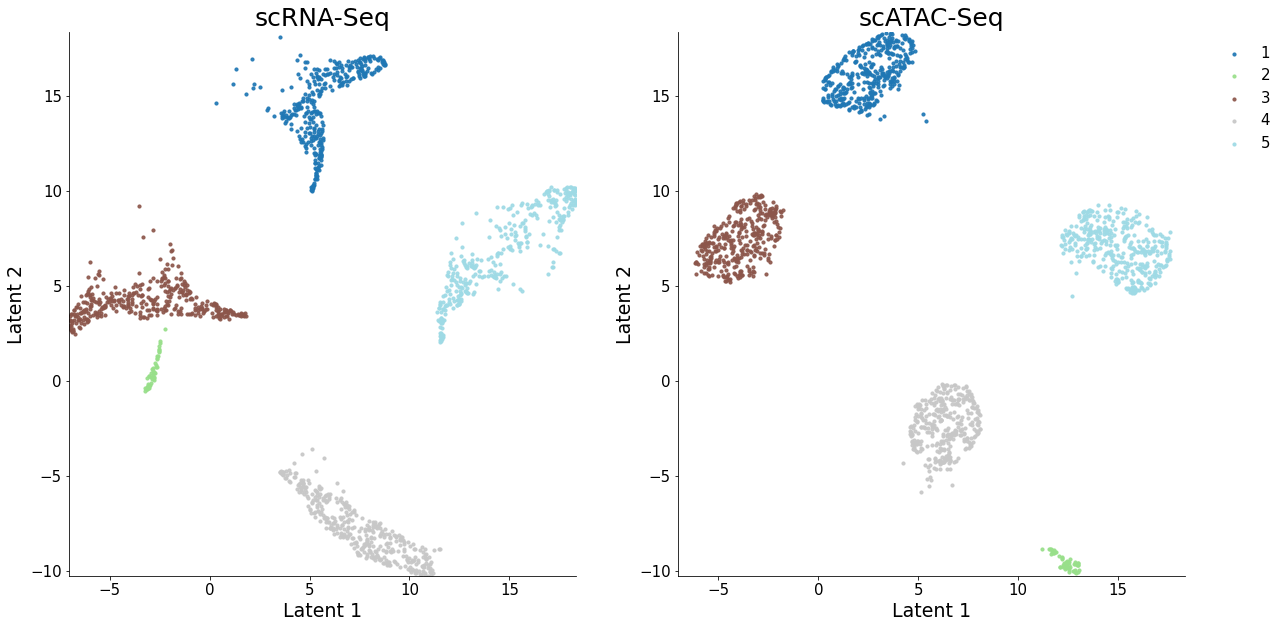

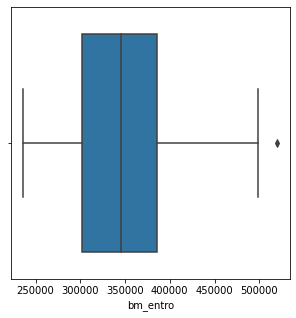

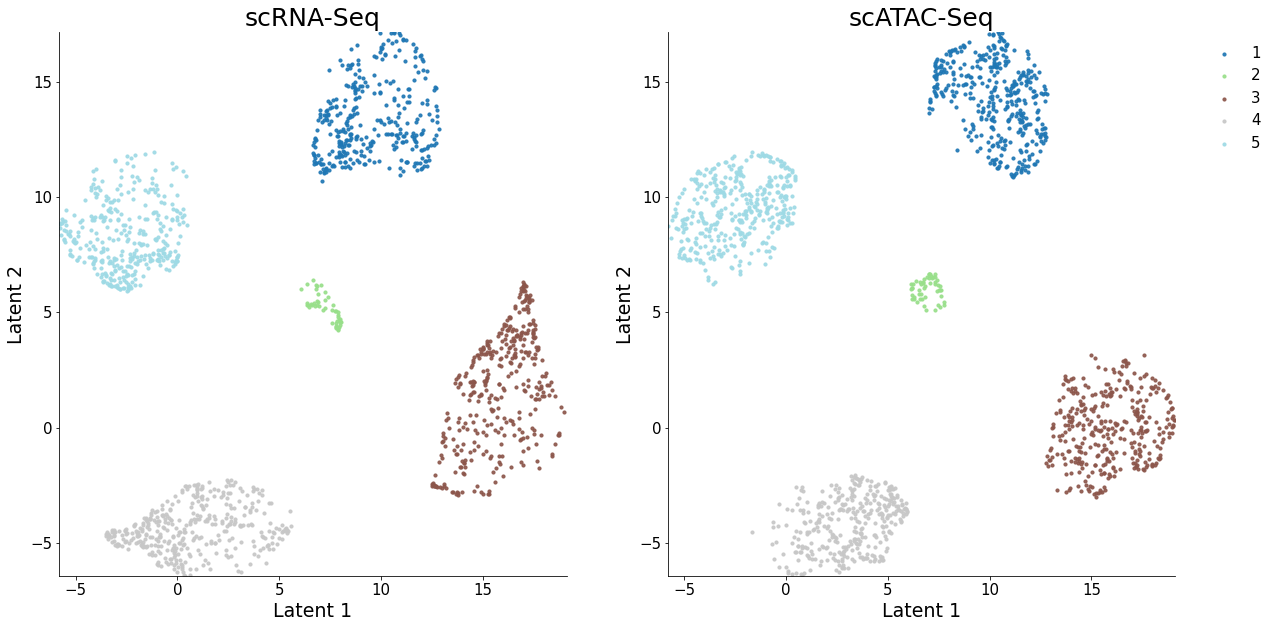

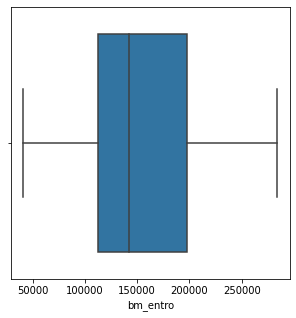

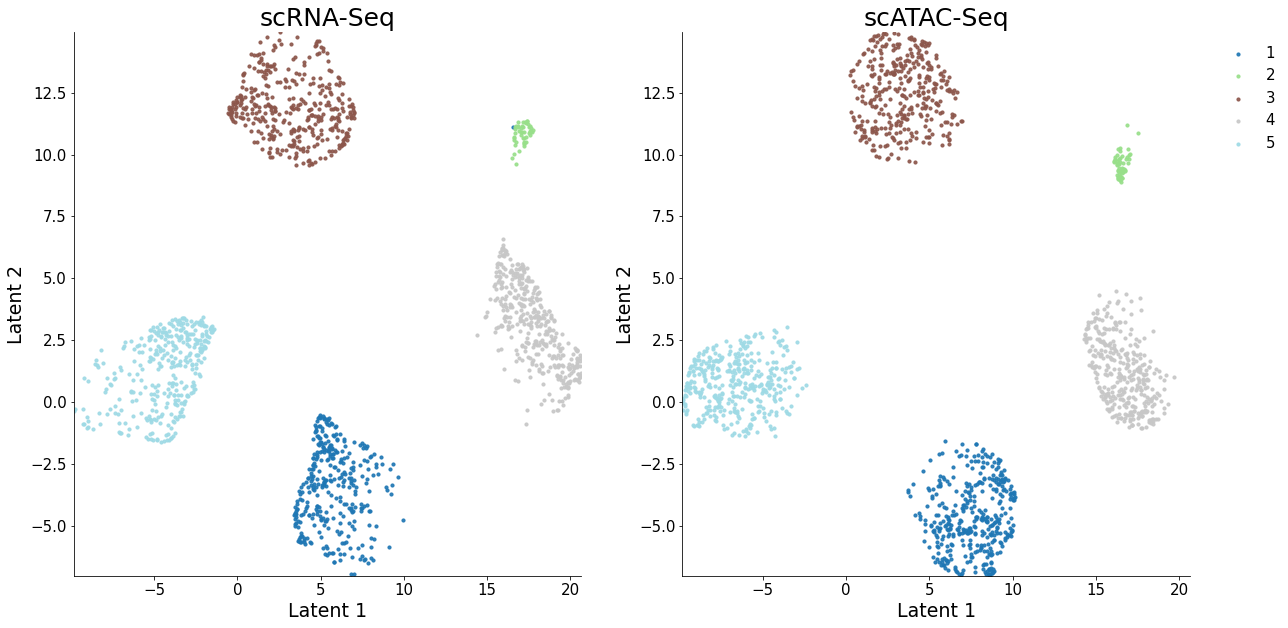

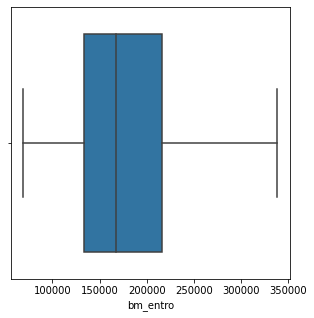

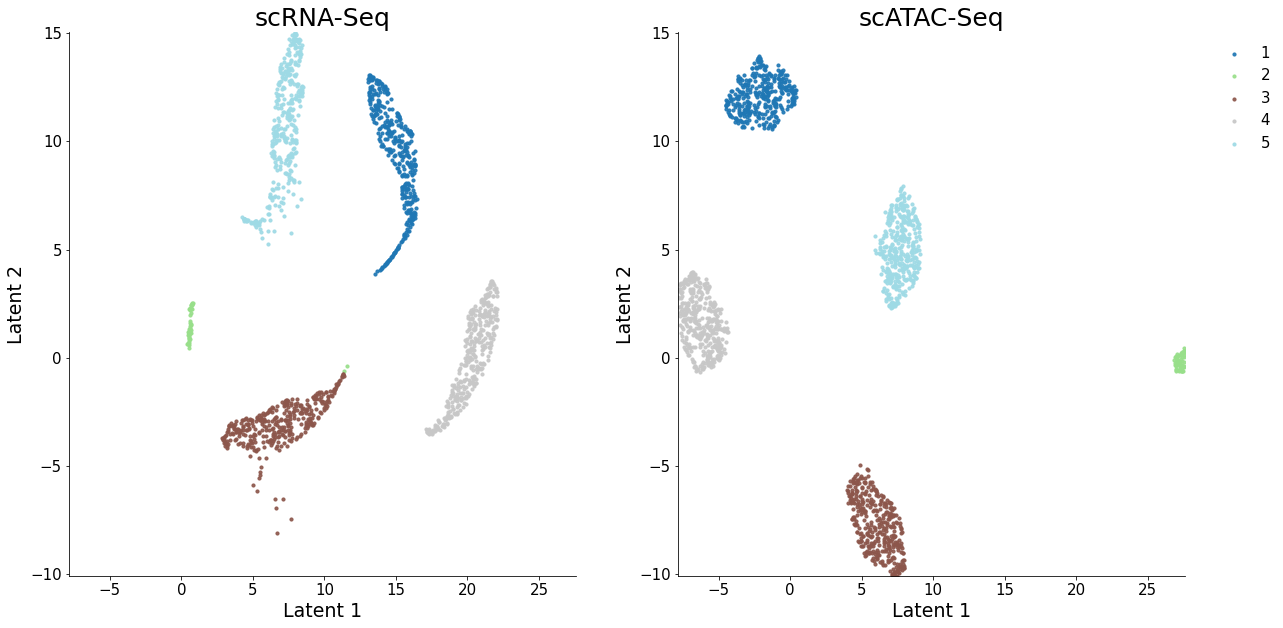

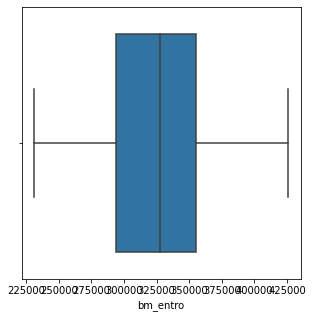

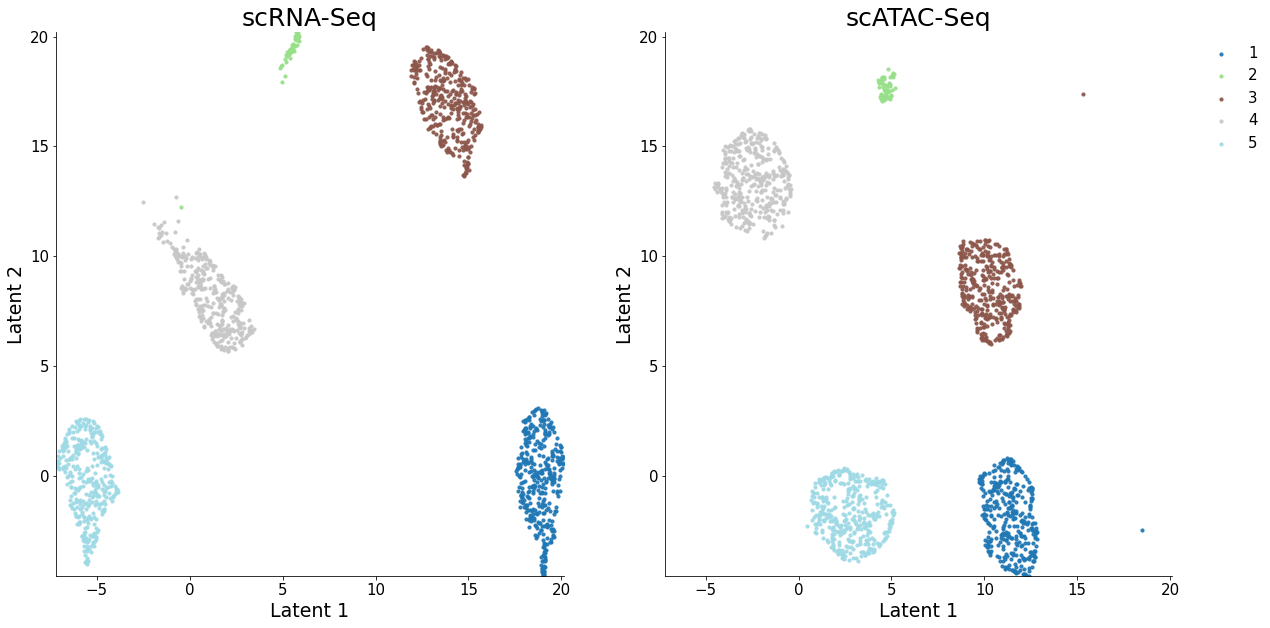

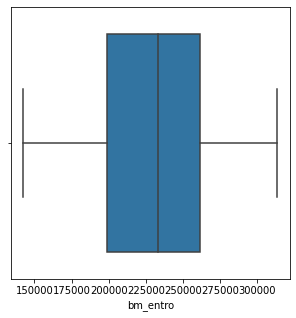

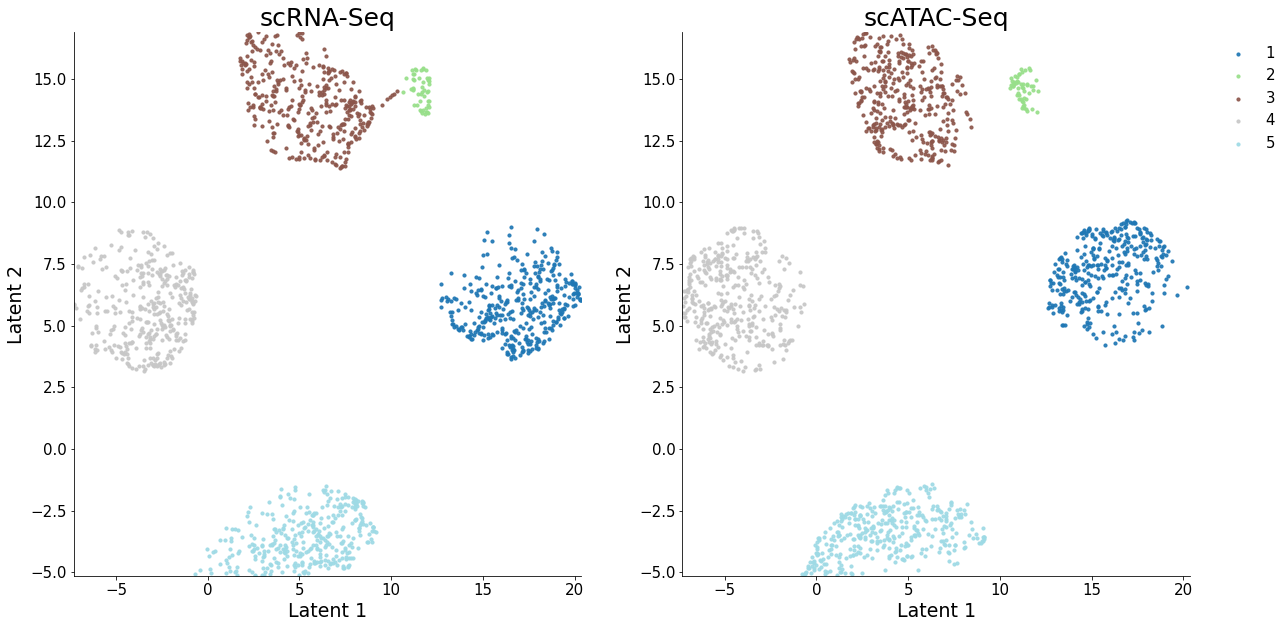

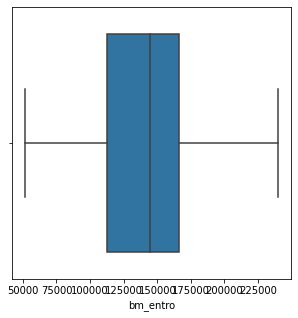

In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
from torch.nn import Module, Parameter
from utils import preprocess
import torch.nn.functional as F

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp

from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

import newmodel
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#######################################################################

# Test on simulated dataset

#######################################################################


def batch_mixing_entropy(C1, C2, runs = 1):
    # construct knn graph
    k = 100
    
    C = torch.cat((C1, C2), dim = 0)
    dist = utils._pairwise_distances(C, C).numpy()
    knn_index = np.argpartition(dist, kth = k - 1, axis = 1)[:,(k-1)]
    kth_dist = np.take_along_axis(dist, knn_index[:,None], axis = 1)
    knn = ((dist - kth_dist[:, None]) <= 0)


    # select random anchors, and calculate the entropy
    entropys = []
    for run in range(runs):
        random_anchor = np.random.choice(C1.shape[0] + C2.shape[0], 100, replace=False)
        p1 = np.sum(knn[random_anchor,:C1.shape[0]], axis = 1)/100
        p2 = np.sum(knn[random_anchor,C1.shape[0]:], axis = 1)/100
        entropys.append(np.sum(p1 * np.log(p1 + 1e-6)) + np.sum(p2 * np.log(p2 + 1e-6)))
    return np.array(entropys)
    
    
# Read in the data: 2 batches, 3 clusters
dir = '../data/simulated/'

paths = ['2b5c_ziqi1/', '2b5c_ziqi2/']

for path in paths:
    for init in ["SVD", "NMF", "random"]:
        latent_dim = 5
        batchsize = 0.5
        
        best_loss = 1e12
        kl1 = []
        kl2 = []
        
        losses = []
        ari_scores = []
        for run in range(1):
            print("data: "+ path[:-1] + "\ninit: "+ init + 
                  "\nbatch_size: "+ str(batchsize) + "\nrun: "+ str(run))
            
            # read in the data
            counts_rna = pd.read_csv(os.path.join(dir + path, 'GxC1.txt'), sep = "\t", header = None).values.T
            counts_atac = pd.read_csv(os.path.join(dir + path, 'RxC2.txt'), sep = "\t", header = None).values.T
            A = pd.read_csv(os.path.join(dir + path, 'region2gene.txt'), sep = "\t", header = None).values.T

            counts_rna = np.array(counts_rna)
            counts_atac = np.array(counts_atac)
            A = np.array(A)
            counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}
            
            # init
            if init == "SVD":
                model_init = newmodel.cfrm_svdinit(counts, N = latent_dim).to(device)
                C_1, C_2, A_g, A_r, C_g, C_r = model_init.train_func(match = True)
                init_val = [C_1, C_2, A_g, A_r, C_g, C_r]
            elif init == "NMF":
                model1 = newmodel.cfrm_nmfinit(counts, N = 5, batch_size = 0.5, lr = 1e-3, seed = 0).to(device)
                C_1, C_2, A_g, A_r, C_g, C_r = model1.train_func(T = 500, match = True)
                init_val = [C_1, C_2, A_g, A_r, C_g, C_r]
            else:
                init_val = None

            # train model
            model1 = newmodel.cfrm_new(counts, N = latent_dim, batch_size = batchsize, interval=20000, lr=1e-3, 
                                       alpha = [1000, 1000, 100, 100], seed = run, init = init_val).to(device)

            model1.train_func(T = 10000)

            # validation
            with torch.no_grad():
                loss, *_ = model1.batch_loss('valid')
                print('Final Loss is {:.5f}'.format(loss.item()))
                print()

            # save the best of all runs
            if loss < best_loss:
                torch.save(model1.state_dict(), "./results/models/" + path[:-1] + "_" + init + "_" + "_best.pt")

            # plots
            umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

            z_rna = model1.softmax(model1.C_1.cpu().detach()).numpy()
            z_atac = model1.softmax(model1.C_2.cpu().detach()).numpy()


            max_rna = np.argmax(z_rna, axis = 1).squeeze()
            max_atac = np.argmax(z_atac, axis = 1).squeeze()
            z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

            label_rna = pd.read_csv(os.path.join(dir + path, "cell_label1.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()
            label_atac = pd.read_csv(os.path.join(dir + path, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()
            utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = "./results/plots/" + path[:-1] + "_" + init + "_" + str(run) + ".png")

            # kl divergence
            kl1.append(utils.kl_div(model1.softmax(model1.C_1)).item())
            kl2.append(utils.kl_div(model1.softmax(model1.C_2)).item())
            losses.append(loss.item())

            # benchmark how??
            # batch mixing entropy
            bm_entro = batch_mixing_entropy(model1.softmax(model1.C_1.cpu().detach()), 
                                            model1.softmax(model1.C_2.cpu().detach()), runs = 50)
            np.save( "./results/" + path[:-1] + "_" + init + "_" + str(run) + "_bm_enropy.npy", np.array(bm_entro))
            fig = plt.figure(figsize = (5,5))
            ax = fig.add_subplot()
            sns.boxplot(x = pd.DataFrame(data = bm_entro[:,None], columns = ["bm_entro"])["bm_entro"], ax = ax)
            fig.savefig("./results/"+ path[:-1] + "_" + init + "_" + str(run) + "_bm_enropy.png")


            # ARI score, same as what is used in Fabian benchmark code
            ari_scores.append(adjusted_rand_score(labels_pred = np.concatenate((max_rna, max_atac), axis = 0), labels_true = np.concatenate((label_rna, label_atac), axis = 0)))
        np.save( "./results/" + path[:-1] + "_" + init + "_ari.npy", np.array(ari_scores))
        np.save( "./results/" + path[:-1] + "_" + init + "_loss.npy", np.array(losses))
            # alignment score (in liger), knn graph, local structure metric (in seurat v3)



        kl = np.array(kl1.append(kl2))
            
        # save kl divergence
        np.save("./results/" + path[:-1] + "_" + init + "_kl.npy", kl)
            

